In [44]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

## Подключение к базе данных

In [45]:
conn = sqlite3.connect('../data/checking-logs.sqlite', check_same_thread=False)

## Анализировать только пользователей, а не администраторов

In [46]:
query = """
SELECT 
    uid,timestamp
FROM
    checker
WHERE 
    uid LIKE 'user_%'
"""
commits = pd.io.sql.read_sql(query,conn, parse_dates=['timestamp'])
commits['weekday'] = commits['timestamp'].dt.dayofweek
commits['day'] = commits.timestamp.dt.day
commits['hour'] = commits.timestamp.dt.hour
commits['type'] = commits['weekday'].apply(lambda x: 'Work' if x < 5 else 'Weekend')
commits = commits.drop(columns = 'weekday')
commits

,uid,timestamp,day,hour,type
0,user_4,2020-04-17 05:19:02.744528,17,5,Work
1,user_4,2020-04-17 05:22:35.249331,17,5,Work
2,user_4,2020-04-17 05:22:45.549397,17,5,Work
3,user_4,2020-04-17 05:34:14.691200,17,5,Work
4,user_4,2020-04-17 05:34:24.422370,17,5,Work
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,21,20,Work
3203,user_1,2020-05-21 20:22:41.785725,21,20,Work
3204,user_1,2020-05-21 20:22:41.877806,21,20,Work
3205,user_1,2020-05-21 20:37:00.129678,21,20,Work


## Создать два списка значений (для рабочих дней и для выходных) для ввода гистограммы

In [47]:
working_day = commits[commits['type'] == 'Work'][['hour']].reset_index(drop=True)
working_day

,hour
0,5
1,5
2,5
3,5
4,5
...,...
2032,20
2033,20
2034,20
2035,20


In [48]:
len(working_day)

2037

In [49]:
weekend_day = commits[commits['type'] == 'Weekend'][['hour']].reset_index(drop=True)
weekend_day

,hour
0,7
1,13
2,13
3,13
4,13
...,...
1165,22
1166,22
1167,22
1168,22


In [50]:
len(weekend_day)

1170

## Создать гистограмму

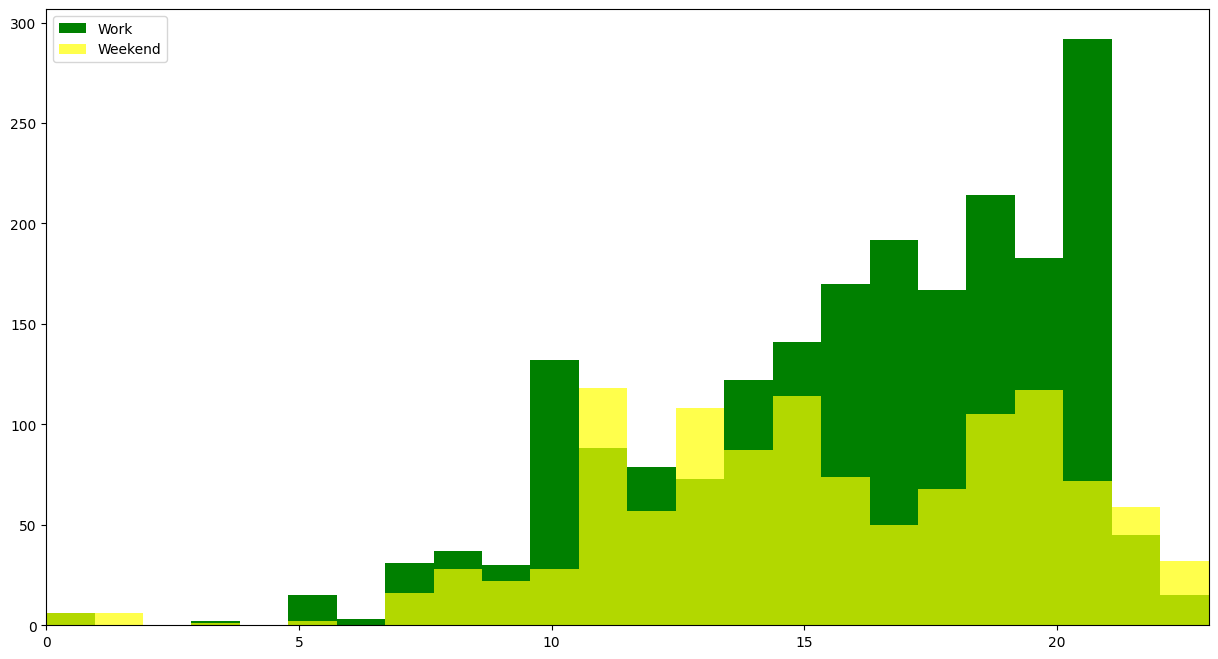

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(working_day['hour'],
        bins=24,
        label='Work',
        color='green')
ax.hist(weekend_day['hour'],
        bins=24,
        label='Weekend',
        color='yellow',
        alpha=0.7)
ax.set_xlim(0, 23)
ax.legend(loc='upper left', fontsize='10')

## «Бывают ли часы, когда общее количество коммитов в выходные дни выше, чем в рабочие?» 
- В своём ответе приведите 4 примера.

In [52]:
commits_group = commits.groupby(['type', 'hour']).count()['uid'].reset_index()
pivot_table = pd.pivot_table(commits_group, values='uid', index='hour', columns = 'type')
table_res = pivot_table[pivot_table['Weekend'] > pivot_table['Work']]
table_res

type,Weekend,Work
hour,,
11,118.0,88.0
13,108.0,73.0
22,59.0,45.0
23,32.0,15.0


## В 11, 13, 22, 23 часа коммитов в выходные было сделано больше чем в будние

## Закрыть соединение с базой данных

In [53]:
conn.close()